# Metody Obliczeniowe w Nauce i Technice 

## Labolatorium nr 2

#### Patryk Klatka
#### 22 marca 2023

## Wstęp

Celem labolatorium było zapoznanie się z metodami obliczania układów równań liniowych. Została przeanalizowana metoda Gaussa-Jordana oraz faktoryzacji LU. Dodatkowo, został wykonany program, który oblicza natężenia prądu w obwodzie elektrycznym za pomocą praw Kirchoffa. Program ten miał na celu zapoznania się z metodami radzenia sobie z nadokreślonym układem równań.

Sprawozdanie zostało napisane w Jupyter Notebooku, w celu przedstawienia nie tylko wniosków z przeprowadzonego labolatorium, ale również kodu, który został wykorzystany do jego wykonania.

## Import bibliotek oraz ich konfiguracja

W celu wykonywania obliczeń oraz rysowania wykresów, zostały zaimportowane odpowiednie biblioteki. Dodatkowo, zostały ustawione parametry wykresów, tak aby były czytelne.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as plt_colors
import pandas as pd
import networkx as nx
import scipy
import time
from collections import deque

# Matplotlib settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

## Zadanie 1 - Metoda Gaussa-Jordana

Funkcja rozwiązująca układ równań liniowych $n \times n$ metodą Gaussa-Jordana z częściowym poszukiwaniem elementu wiodącego:

In [2]:
def gauss_jordan_method(Ab: np.array) -> np.array:
    """Solve the linear system of equations Ax = b using Gauss-Jordan method.

    Source: https://en.wikipedia.org/wiki/Gaussian_elimination#Pseudocode

    :param np.array Ab: Matrix A augmented with vector b
    :return np.array: Vector x
    """
    h = 0
    k = 0

    while h < Ab.shape[0] and k < Ab.shape[1]:
        # Find the k-th pivot
        i_max = np.argmax(np.abs(Ab[h:, k])) + h # Why + h? Because we only want to search in the rows below the h-th row, and Ab[h:, k] returns new array

        if np.isclose(Ab[i_max, k], 0.0):
            # Matrix is singular
            k += 1
            continue

        # Scale the h-th row
        Ab[h] = Ab[h] / np.max(np.abs(Ab[h, :]))

        # Swap the k-th row with the i_max-th row
        Ab[[k, i_max]] = Ab[[i_max, k]]
        
        # For all rows below the k-th row, subtract the k-th row scaled by a factor of f
        for i in range(h + 1, Ab.shape[0]):
            f = Ab[i, k] / Ab[h, k]
            Ab[i] = Ab[i] - f * Ab[h]

        h += 1
        k += 1

    # Backward substitution, to read solution
    x = np.zeros(Ab.shape[0])

    x[-1] = Ab[-1, -1] / Ab[-1, -2]
    for i in range(Ab.shape[0] - 2, -1, -1):
        s = np.sum(Ab[i, i + 1:-1] * x[i + 1:]) # Sum all variables multiplied by their coefficients
        x[i] = (Ab[i, -1] - s) / Ab[i, i]
    
    return x

### Przykładowe wywołania i testowanie poprawności działania funkcji:

In [3]:
A = np.array([
    [5, 8, -4],
    [6, 9, -5],
    [4, 7, -2]
]).astype(np.float64)
b = np.array([2, -3, 1]).astype(np.float64)
Ab = np.concatenate((A, b[:, np.newaxis]), axis=1)

x = gauss_jordan_method(Ab.copy())
numpy_x = np.linalg.solve(A.copy(), b.copy())

print(f"Solution: {x}")
print(f"Solution (numpy): {numpy_x}")
print(f"Error between implementations: {np.linalg.norm(x - numpy_x)}")
print(f"Error after calculations: {np.linalg.norm(A @ x - b)}")

Solution: [-22.  11.  -6.]
Solution (numpy): [-22.  11.  -6.]
Error between implementations: 1.0330778860635373e-13
Error after calculations: 2.0097183471152322e-14


In [4]:
A = np.array([
    [0, 7, -1, 3, 1],
    [0, 3, 4, 1, 7],
    [6, 2, 0, 2, -1],
    [2, 1, 2, 0, 2],
    [3, 4, 1, -2, 1]
]).astype(np.float64)
b = np.array([5, 7, 2, 3, 4]).astype(np.float64)
Ab = np.concatenate((A, b[:, np.newaxis]), axis=1)

x = gauss_jordan_method(Ab.copy())
numpy_x = np.linalg.solve(A.copy(), b.copy())

print(f"Solution: {x}")
print(f"Solution (numpy): {numpy_x}")
print(f"Error between implementations: {np.linalg.norm(x - numpy_x)}")
print(f"Error after calculations: {np.linalg.norm(A @ x - b)}")

Solution: [0.03076923 0.78461538 1.01538462 0.15384615 0.06153846]
Solution (numpy): [0.03076923 0.78461538 1.01538462 0.15384615 0.06153846]
Error between implementations: 5.624357682132276e-16
Error after calculations: 8.881784197001252e-16


Analizując powyższe wyniki można stwierdzić, że funkcja działa poprawnie. Błędy obliczeniowe, wyznaczone na podstawie obliczeń innej biblioteki oraz przez pomnożenie macierzy $A$ przez wektor wynikowy, są bardzo małe.

### Porównanie czasu działania algorytmu z biblioteczną funkcją `np.linalg.solve`:

In [5]:
def generate_linear_equations(n: int) -> np.array:
    """Generate a linear system of equations Ax = b.

    :param int n: Number of equations
    :return np.array: Matrix A augmented with vector b
    """
    # Generate a random matrix A
    A = np.random.randint(5, 100, size=(n, n)).astype(np.float64)

    # Generate a random vector b
    b = np.random.randint(5, 100, size=(n,)).astype(np.float64)

    return np.concatenate((A, b[:, np.newaxis]), axis=1)

In [9]:
sizes = [500, 600, 700, 800, 900, 1000, 1200, 1500, 1700, 2000]

numpy_times = []
scipy_times = []
gjelim_times = []

function_name = {
    0: "gauss_jordan_method",
    1: "numpy.linalg.solve",
    2: "scipy.linalg.solve"
}

for size in sizes:
    Ab = generate_linear_equations(size)

    # Test gauss_jordan_method
    Ab_copy = Ab.copy()
    start_time = time.time()
    x = gauss_jordan_method(Ab_copy)
    gjelim_times.append(f"{time.time() - start_time}s")

    # Test numpy.linalg.solve
    Ab_copy = Ab.copy()
    start_time = time.time()
    x2 = np.linalg.solve(Ab_copy[:, :-1], Ab_copy[:, -1])
    numpy_times.append(f"{time.time() - start_time}s")

    # Test scipy.linalg.solve
    Ab_copy = Ab.copy()
    start_time = time.time()
    x3 = scipy.linalg.solve(Ab_copy[:, :-1], Ab_copy[:, -1])
    scipy_times.append(f"{time.time() - start_time}s")


df = pd.DataFrame({
    "gauss_jordan_method": gjelim_times,
    "numpy.linalg.solve": numpy_times,
    "scipy.linalg.solve": scipy_times,
    "winner": list(map(lambda x: function_name[x], np.argmin([gjelim_times, numpy_times, scipy_times], axis=0)))
}, index=sizes)

df.columns.name = "size"
df

size,gauss_jordan_method,numpy.linalg.solve,scipy.linalg.solve,winner
500,0.3307778835296631s,0.001577138900756836s,0.0064389705657958984s,numpy.linalg.solve
600,0.48276782035827637s,0.033168792724609375s,0.04127216339111328s,numpy.linalg.solve
700,0.6485991477966309s,0.003538846969604492s,0.007977008819580078s,numpy.linalg.solve
800,0.8624429702758789s,0.006327152252197266s,0.009939908981323242s,numpy.linalg.solve
900,1.1233749389648438s,0.006941795349121094s,0.011347055435180664s,numpy.linalg.solve
1000,1.3726298809051514s,0.009220123291015625s,0.017146825790405273s,numpy.linalg.solve
1200,2.047477960586548s,0.021199941635131836s,0.02771306037902832s,numpy.linalg.solve
1500,3.346719980239868s,0.029651880264282227s,0.040968894958496094s,numpy.linalg.solve
1700,4.4968180656433105s,0.05852913856506348s,0.06844902038574219s,numpy.linalg.solve
2000,6.675595045089722s,0.07706093788146973s,0.10071992874145508s,numpy.linalg.solve


### Wnioski
Dla wszystkich przypadków, funkcje biblioteczne wykonywały krócej obliczenia niż funkcja `gauss_jordan_method`. Z funkcji bibliotecznych najlepiej radziła sobie funkcja `solve` z pakietu `numpy.linalg`, jednakże różnice w czasie działania z `scipy.linalg.solve` były niewielkie. 

## Zadanie 2 - Faktoryzacja LU

Funkcja dokonująca faktoryzacji $A=LU$ macierzy $A$, bez poszukiwania elementu wiodącego:

In [10]:
def lu_factorization(A: np.array) -> np.array:
    """LU factorization of a matrix A. It uses similar algorithm as Gauss-Jordan method.

    :param np.array A: Matrix A, which, after factorization, will be matrix U
    :return np.array: L matrix
    """

    h = 0
    k = 0

    L = np.eye(A.shape[0], dtype=np.float64)

    while h < A.shape[0] and k < A.shape[1]:
        # For all rows below the k-th row
        for i in range(h + 1, A.shape[0]):
            f = A[i, k] / A[h, k]
            L[i, h] = f
            A[i] = A[i] - f * A[h]

        h += 1
        k += 1

    return L

### Przykładowe wywołanie funkcji:

In [11]:
A = np.array([
    [5, 8, -4],
    [6, 9, -5],
    [4, 7, -2]
]).astype(np.float64)

U = A.copy()
L = lu_factorization(U)

print("A matrix:")
print(A)
print("L matrix:")
print(L)
print("U matrix:")
print(U)
print(f"\n|| A - LU || = {np.abs(A - (L @ U)).sum()}")


A matrix:
[[ 5.  8. -4.]
 [ 6.  9. -5.]
 [ 4.  7. -2.]]
L matrix:
[[ 1.   0.   0. ]
 [ 1.2  1.   0. ]
 [ 0.8 -1.   1. ]]
U matrix:
[[ 5.   8.  -4. ]
 [ 0.  -0.6 -0.2]
 [ 0.   0.   1. ]]

|| A - LU || = 0.0


### Testowanie poprawności:

In [12]:
def test_lu_factorization(size: int) -> None:
    """Test LU factorization.

    :param int size: Size of the matrix
    :return int: Error of LU factorization
    """
    A = generate_linear_equations(size)[:, :-1]

    U = A.copy()
    L = lu_factorization(U)
    
    return np.abs(A - (L @ U)).sum()

def test_scipy_linalg_lu(size: int) -> None:
    """Test LU factorization from scipy.

    :param int size: Size of the matrix
    :return int: Error of LU factorization
    """
    A = generate_linear_equations(size)[:, :-1]

    L, U = scipy.linalg.lu(A, permute_l=True)
    
    return np.abs(A - (L @ U)).sum()

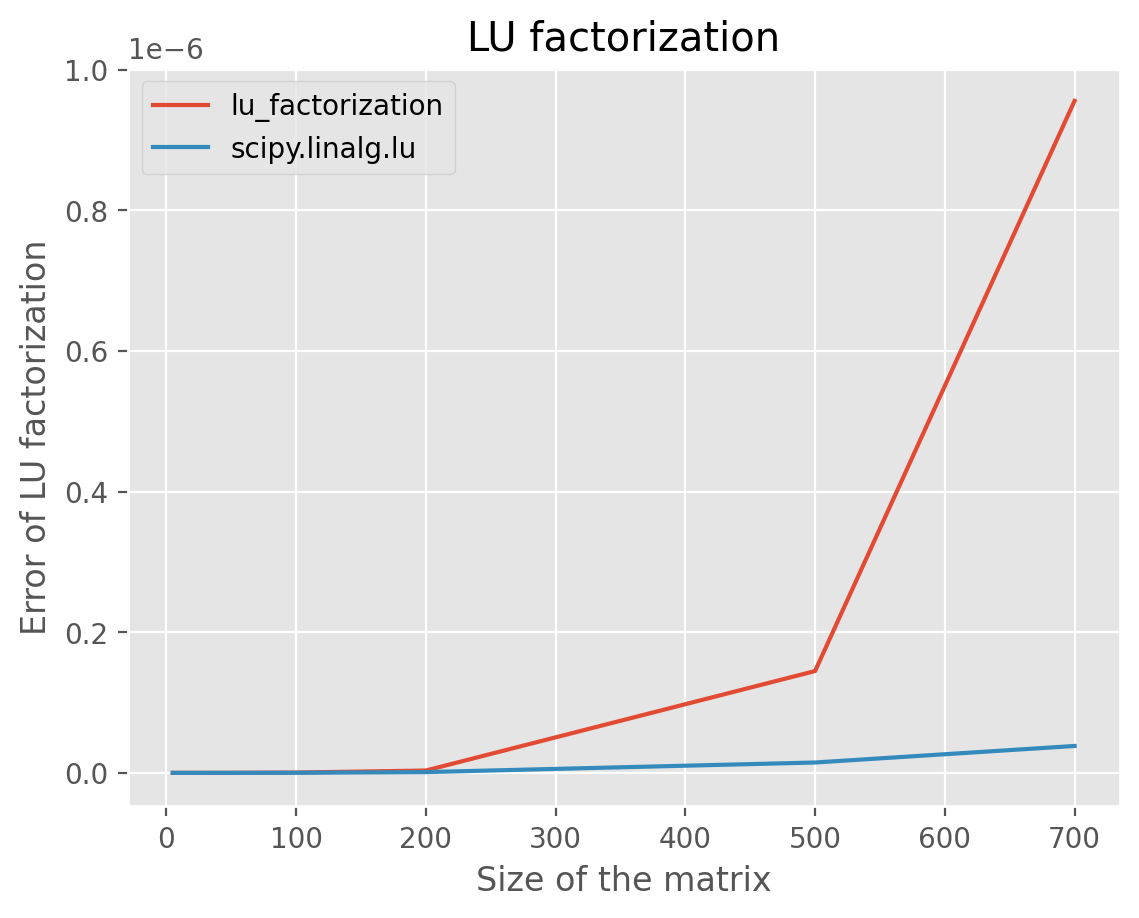

In [13]:
sizes = [5, 10, 20, 50, 100, 200, 500, 700]

errors = [test_lu_factorization(size) for size in sizes]
scipy_errors = [test_scipy_linalg_lu(size) for size in sizes]

plt.title("LU factorization")
plt.plot(sizes, errors)
plt.plot(sizes, scipy_errors)
plt.legend(["lu_factorization", "scipy.linalg.lu"])
plt.xlabel("Size of the matrix")
plt.ylabel("Error of LU factorization")
plt.show()

### Wnioski
W porównaniu wyników wyrażenia $||A - LU||$ dwóch różnych implementacji faktoryzacji dla różnych rozmiarów macierzy, wygrywa implementacja `scipy.linalg.lu`, która miała o wiele mniejsze błędy niż implementacja `lu_factorization`. Jednakże, błędy te były stosunkowo małe, nie przekraczały wartości $10^{-6}$.

## Zadanie 3 - Analiza obwodu elektrycznego - nadokreślony układ równań

Obwód elektryczny jest reprezentowany za pomocą grafu skierowanego, gdzie każda krawędź ma określoną rezystancję. Celem zadania jest obliczenie natężeń prądu w każdej krawędzi, znając przyłożoną siłę elektromotoryczną.

### Podejście do zadania

W celu obliczenia natężeń zostało wykorzystane prawo Kirchhoffa. Pierwsze prawo Kirchoffa mówi o zachowaniu ilości prądu w każdym węźle grafu (natężenia prądów wychodzących z węzła równają się natężeniom prądów wchodzących do węzła). Drugie prawo Kirchoffa dotyczy sumy wszystkich napięć w każdym cyklu grafu (suma napięć w cyklu równa się przyłożonej sile elektromotorycznej).

Wykorzystując powyższe prawo, aby obliczyć natężenia należy:
1. Dla danego układu nadać odpowiednie kierunki prądom.
2. Wygenerować m równań związanych z pierwszym prawem Kirchhoffa.
3. Wygenerować n - m równań związanych z drugim prawem Kirchhoffa.
4. Obliczyć układ równań.
5. Obrócić kierunki prądów, jeżeli wynik natężenia jest ujemny.

W celu znalezienia początkowych kierunków prądów, wykonywane jest proste przeuszkiwanie wszerz, zaimplmenetowane w metodzie `initialize_directed_graph`. Po obliczeniu natężeń, jeżeli natężenie jest ujemne, to kierunek prądu jest zmieniany na przeciwny (krawędź grafu skierowanego jest odwracana).

Za znajdowanie oczek w obwodzie, potrzebnych do wyznaczenia równań z drugiego prawa Kirchoffa, odpowiada funkcja `cycle_basis` z biblioteki `networkx`. Funkcja ta zwraca listę list, gdzie każda lista zawiera wierzchołki cyklu prostego. Funkcja gwarantuje, że zwracana lista jest minimalnym zbiorem cyklów, takich, że jakikolwiek cykl w grafie może zostać zapisany jako suma cykli (XOR krawędzi cykli) w tej liście. Funkcja jest wywoływana na grafie nieskierowanym. W poniższych przykładach zazwyczaj liczba cykli wyznaczanych z funkcji `cycle_basis` wystarczała do utworzenia odpowiedniej liczby układów równań. Przykładem, gdzie potrzebne było wygenerowanie dodatkowych cykli jest obwód reprezentowany przez siatkę 3x3. 

Punkt 4. można wykonać na dwa sposoby. Możemy wykonać układ $n \times n$, ale możemy również utworzyć układ nadokreślony. Wtedy za pomocą metody najmniejszych kwadratów (`np.linalg.lstsq`) możemy obliczyć przybliżone rozwiązanie układu równań, wykorzystując wszystkie równania z pirwszego i drugiego prawa Kirchhoffa. Może to być przydatne, gdy macierz $A$ jest nieodwracalna.

Po każdym wykonaniu obliczeń wykonywane jest sprawdzenie poprawności obliczeń. Dla każdej krawędzi grafu sprawdzane jest, czy natężenie jest mniejsze od natężenia prądu przy krawędzi gdzie została przyłożona siła elektromotoryczna. Dodatkowo sprawdzane jest czy spełnione jest pierwsze prawo Kirchhoffa, z odpowiednim dopuszczalnym błędem, w przypadku korzystania z metody najmniejszych kwadratów.

### Uwagi implementacyjne

Klasa `Circuit` zawiera następujące metody:

- Wczytywanie/zapisywanie grafu nieskierowanego ważonego z pliku.
- Metoda nadająca wstępne kierunki prądów.
- Metoda generująca równania z praw Kirchhoffa oraz obliczająca układ równań (nadokreślony lub nie).
- Metoda sprawdzająca poprawność obliczeń.
- Metoda rysująca graf.

Konwencja pliku z obwodem elektrycznym:
- Każda krawędź grafu jest postaci: `e wierzchołek_początkowy wierzchołek_końcowy wartość_rezystancji`.
- Przyłożona siła elektromotoryczna E jest postaci: `sem wierzchołek_początkowy wierzchołek_końcowy wartość_siły`.
- Gdy brak wpisu o sile elektromotorycznej, pojawi się okno zapytujące o wartość siły oraz wierzchołki, między którymi ma zostać przyłożona.
- Wszystkie wpisy są oddzielone znakiem nowej linii.

In [3]:
class Circuit:
    def __init__(self, graph=None, filename=None) -> None:
        self.directed_graph = nx.DiGraph()
        self.undirected_graph = nx.Graph()
        self.sem = (-1,-1,-1)
        self.circuit_nodes = []

        # Run constructors
        if graph != None and filename == None:
            self.initialize_graph(graph)

        if graph == None and filename != None:
            self.read_graph_from_file(filename)

    def initialize_graph(self, graph, sem = (-1,-1,-1)):
        """
        Initialize the graph.

        :param nx.Graph graph: Graph
        :param tuple sem: (source, end, max)
        """

        self.undirected_graph = graph
        self.sem = sem

        if self.sem == (-1,-1,-1):
            edges = list(self.undirected_graph.edges)
            self.sem = (edges[0][0], edges[0][1] , np.random.random()*20 + 50)

        # Randomize resistance of edges
        for u, v in self.undirected_graph.edges:
            self.undirected_graph[u][v]["resistance"] = np.random.random()*5

        self.undirected_graph[self.sem[0]][self.sem[1]]["resistance"] = 0

        self.initialize_directed_graph()

    def read_graph_from_file(self, filename: str):
        """Read graph from file.

        :param str filename: Name of the file
        :return: None
        """
        with open(filename, "r") as f:
            lines = f.readlines()

        sem_set = False

        for line in lines:
            if line.startswith("e"):
                _, u, v, w = line.split()
                # Convert to int and float64
                u = int(u)
                v = int(v)
                w = np.float64(w)
                self.undirected_graph.add_edge(u, v)
                self.undirected_graph[u][v]["resistance"] = w
            elif line.startswith("sem"):
                _, u, v, w = line.split()
                # Convert to int and float64
                u = int(u)
                v = int(v)
                w = np.float64(w)
                self.sem = (u, v, w)
                sem_set = True

        if not sem_set:
            sem_val = input("SEM not set!\nEnter value of SEM: ")
            v1 = input(f"Enter first vertex:\nNode list: {self.undirected_graph.nodes}")
            v2 = input(f"Enter second vertex:\nNode list: {self.undirected_graph.nodes}")
            self.sem = (v1, v2, np.float64(sem_val))

        self.initialize_directed_graph()

    def save_graph_to_file(self, filename: str) -> None:
        """Save graph to file.

        :param str filename: Name of the file
        """
        with open(filename, "w") as f:
            if self.sem != (-1,-1,-1):
                f.write(f"sem {self.sem[0]} {self.sem[1]} {self.sem[2]}\n")

            for u, v in self.directed_graph.edges:
                w = self.directed_graph[u][v]["resistance"]
                f.write(f"e {u} {v} {w}\n")
    
    def initialize_directed_graph(self, s=None, t=None) -> nx.DiGraph:
        """Generate directions in directed graph.

        :param int s: first node of the edge
        :param int t: second node of the edge
        """

        if s is None and t is None:
            s, t = self.sem[:2]

        def bfs(G,s,t):
            visited = set()
            queue = deque()

            # Add edge which is an SEM.
            visited.add((min(s,t), max(s,t)))
            self.directed_graph.add_edge(s,t)
            self.directed_graph[s][t]['resistance'] = 0

            queue.append(t)

            while queue:
                v = queue.popleft()
                for u in G.adj[v]:
                    if (min(v,u),max(v,u)) not in visited:
                        visited.add((min(v,u),max(v,u)))
                        queue.append(u)
                        self.directed_graph.add_edge(v, u)
                        self.directed_graph[v][u]['resistance'] = self.undirected_graph[v][u]['resistance']


        bfs(self.undirected_graph, s, t)

    def find_circuit_nodes_in_graph(self):
        """Find circuit nodes in graph.
        """
        
        for node in self.directed_graph.nodes:
            if self.directed_graph.in_degree(node) > 0 and self.directed_graph.out_degree(node) > 0:
                self.circuit_nodes.append(node)


    def generate_n_cycles(self, n, approx=False):
        """Generate cycles in graph.

        :param int n: Number of cycles
        :param bool approx: Approximate cycles
        :return: cycle list
        """
        cycles = nx.cycle_basis(self.undirected_graph)

        if len(cycles) < n:
            # Generate more cycles
            cycles_to_generate = n - len(cycles)
            for i in range(cycles_to_generate):
                for j in range(i+1, len(cycles)):
                    cycle_a = cycles[i]
                    cycle_b = cycles[j]
                    edges_a = [(cycle_a[i], cycle_a[(i+1)%len(cycle_a)]) for i in range(len(cycle_a))]
                    edges_b = [(cycle_b[i], cycle_b[(i+1)%len(cycle_b)]) for i in range(len(cycle_b))]

                    # Get reverse edges as graph undirected
                    edges_a += [e[::-1] for e in edges_a]
                    edges_b += [e[::-1] for e in edges_b]

                    # Find edges that are in either but not in both
                    edges_c = set(edges_a) ^ set(edges_b)

                    tmp_graph = nx.Graph(list(edges_c))


                    try:
                        cycle_to_add = nx.find_cycle(tmp_graph)

                        cycles.append([e[0] for e in cycle_to_add])

                        cycles_to_generate -= 1
                        if cycles_to_generate == 0:
                            return cycles
                    except nx.NetworkXNoCycle:
                        pass

        if approx:
            return cycles

        return cycles[:n]
    
    def calculate_currents(self, approx=False):
        """Generate system of linear equations and calculate currents.

        :param bool approx: If True, then use np.linalg.lstsq to calculate currents.
        """
        
        if len(self.circuit_nodes) == 0:
            self.find_circuit_nodes_in_graph()

        n = len(self.directed_graph.edges)
        cycles = self.generate_n_cycles(n - len(self.circuit_nodes), approx)
        
        no_of_equations = len(self.circuit_nodes) + len(cycles)

        A = np.zeros((no_of_equations, n))
        b = np.zeros(no_of_equations)

        # For each edge assign index, which is an index in matrix A.
        edge_to_index = {}
        for i, (u, v) in enumerate(self.undirected_graph.edges):
            edge_to_index[(u, v)] = i
            edge_to_index[(v, u)] = i

        s,t,sem = self.sem
            
        i = 0
        # Generate equations for each node.
        for node in self.circuit_nodes:
            if i >= no_of_equations:
                break

            # Get edges out of node.
            edges_out = self.directed_graph.out_edges(node)
            # Get edges into node.
            edges_in = self.directed_graph.in_edges(node)

            # Get index of edges.
            indices_out = [edge_to_index[edge] for edge in edges_out]
            indices_in = [edge_to_index[edge] for edge in edges_in]

            # Add equations to matrix A.
            for index in indices_out:
                A[i, index] = 1

            for index in indices_in:
                A[i, index] = -1

            i += 1

        # Generate equations for each cycle.
        for cycle in cycles:
            if i >= no_of_equations:
                break

            # Get edges in cycle.
            edges = [(cycle[i], cycle[(i+1)%len(cycle)]) for i in range(len(cycle))]

            # Get index of edges.
            indices = [edge_to_index[edge] for edge in edges]

            # Get resistance of edges.
            resistances = [self.undirected_graph[edge[0]][edge[1]]["resistance"] for edge in edges]

            # Add equations to matrix A.
            for j in range(len(indices)):
                # Get edge
                edge = edges[j]
                # Get index of edge.
                index = indices[j]
                # Get resistance of edge.
                resistance = resistances[j]

                # Get direction of edge.
                if edge[0] == s and edge[1] == t:
                    b[i] = sem if edge in self.directed_graph.edges else -sem

                direction = 1 if edge in self.directed_graph.edges else -1
                A[i, index] = resistance * direction

            i += 1

        if approx:
            x = np.linalg.lstsq(A, b, rcond=None)[0]
        else:
            x = np.linalg.solve(A,b)

        for edge in list(self.directed_graph.edges):
            index = edge_to_index[edge]
            if x[index] > 0:
                self.directed_graph[edge[0]][edge[1]]["current"] = x[index]
            else:
                # Reverse edge
                edge_resistance = self.directed_graph[edge[0]][edge[1]]["resistance"]
                self.directed_graph.remove_edge(edge[0], edge[1])
                self.directed_graph.add_edge(edge[1], edge[0])
                self.directed_graph[edge[1]][edge[0]]["resistance"] = edge_resistance
                self.directed_graph[edge[1]][edge[0]]["current"] = -x[index]

                if edge[0] == s and edge[1] == t:
                        self.sem = (edge[1], edge[0], self.sem[2])

            self.undirected_graph[edge[0]][edge[1]]["current"] = x[index]
            self.undirected_graph[edge[1]][edge[0]]["current"] = -x[index]

    def check_circuit(self, print_msg=False, epsilon=1e-5):
        """Check if circuit is valid, using Kirchoff laws.

        :param print_msg: Print message if circuit is not valid.
        :param epsilon: Epsilon for checking if two numbers are close.
        """

        error = False

        # Kirchoff laws
        for node in self.directed_graph.nodes:
            # Get edges out of node.
            edges_out = self.directed_graph.out_edges(node)
            # Get edges into node.
            edges_in = self.directed_graph.in_edges(node)

            # Get currents of edges.
            currents_out = [self.directed_graph[edge[0]][edge[1]]["current"] for edge in edges_out]
            currents_in = [self.directed_graph[edge[0]][edge[1]]["current"] for edge in edges_in]

            # Check if Kirchoff laws are satisfied.
            if len(currents_in) > 0 and len(currents_out) > 0 and not np.isclose(np.sum(currents_in), np.sum(currents_out), atol=epsilon):
                if print_msg:
                    print(f"Kirchoff laws are not satisfied for node: {node}, {np.abs(np.sum(currents_in) - np.sum(currents_out))}")
                error = True
            
        # Current should be less than in edge with sem.
        s,t,sem = self.sem

        current = self.directed_graph[s][t]["current"]

        for edge in self.directed_graph.edges:
            if edge[0] == s and edge[1] == t:
                continue

            if self.directed_graph[edge[0]][edge[1]]["current"] > current:
                if print_msg:
                    print(f"Current is greater than in edge with sem: {edge}")

                error = True
        

        if not error and print_msg:
            print("Circuit currents are correct.")
            
        return not error

    def plot(self):
        """Plot graph.
        """

        pos = nx.spring_layout(self.undirected_graph)
        nx.draw_networkx_nodes(self.directed_graph, pos, node_size=200)
        nx.draw_networkx_edges(self.directed_graph, pos, arrows=True)
        nx.draw_networkx_labels(self.directed_graph, pos, font_size=10, font_family="sans-serif")
        plt.show()

    def plot_circuit(self, show_currents=False):
        """Plot circuit.

        :param bool show_currents: Show currents on edges
        """

        pos = nx.spring_layout(self.undirected_graph)

        # Max current
        s,t = self.sem[:2]
        max_current = self.directed_graph[s][t]["current"]

        # Edges
        ratios = [abs(self.directed_graph[u][v]["current"]/max_current) for u, v in self.directed_graph.edges]
        colors = [plt_colors.to_hex(plt_colors.hsv_to_rgb((ratio*0.4, 0.9, 0.9))) for ratio in ratios]
        nx.draw_networkx_edges(self.directed_graph, pos, edge_color=colors, width=1.2)

        # Nodes
        nx.draw_networkx_nodes(self.directed_graph, pos, node_size=100)

        # Node labels
        nx.draw_networkx_labels(self.directed_graph, pos, font_size=8)

        # Edge weight labels
        if show_currents:
            edge_labels = nx.get_edge_attributes(self.directed_graph, "current")
            edge_labels = {k: np.round(v, 2) for k, v in edge_labels.items()}
            nx.draw_networkx_edge_labels(self.directed_graph, pos, edge_labels)

        plt.axis("off")
        plt.show()

### Działanie programu

W celu przetestowania programu zostały rozważone grafy:
- Spójny graf losowy (Erdos-Renyi)
- Graf 3-regularny (kubiczny)
- Graf złożony z dwóch grafów losowych połaczonych mostkiem
- Graf siatka 2D
- Graf typu small-world

Wszystkie układy mają losowo wygenerowaną wartość rezystancji krawędzi oraz siły elektromotorycznej.

#### Graf 3-regularny (kubiczny)

Circuit currents are correct.


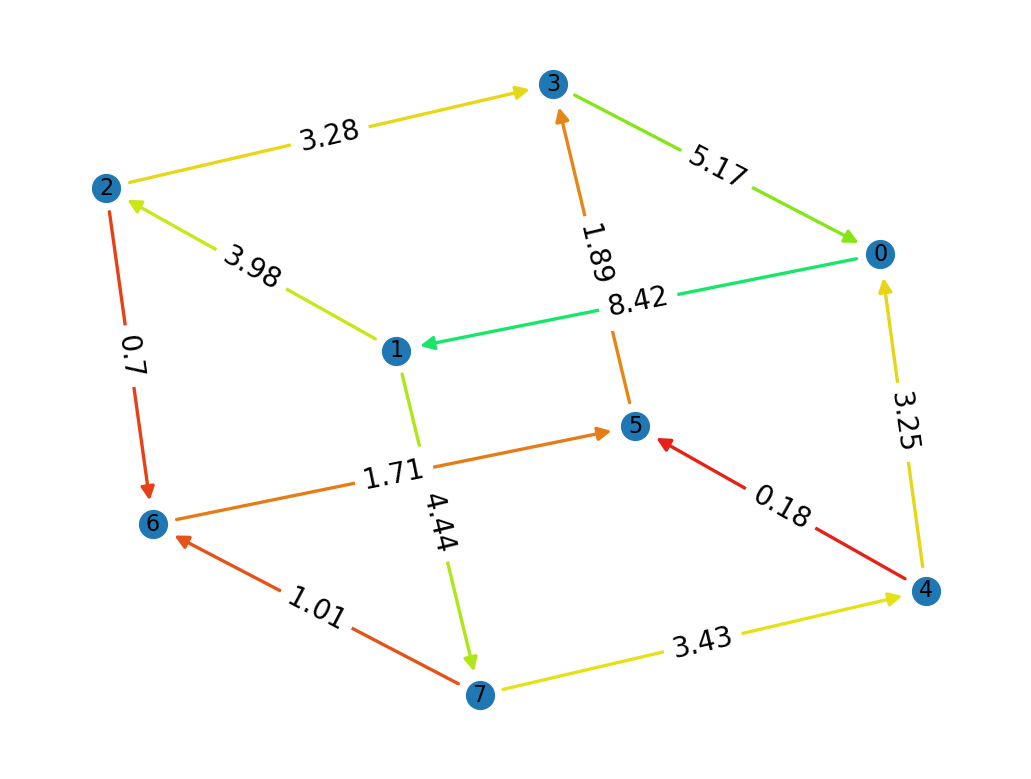

In [4]:
circuit = Circuit(filename="./graphs/cubic/cubic.txt")
circuit.calculate_currents()
circuit.check_circuit(print_msg=True)
circuit.plot_circuit(show_currents=True)

#### Spójny graf losowy (Erdos-Renyi)

Circuit currents are correct.


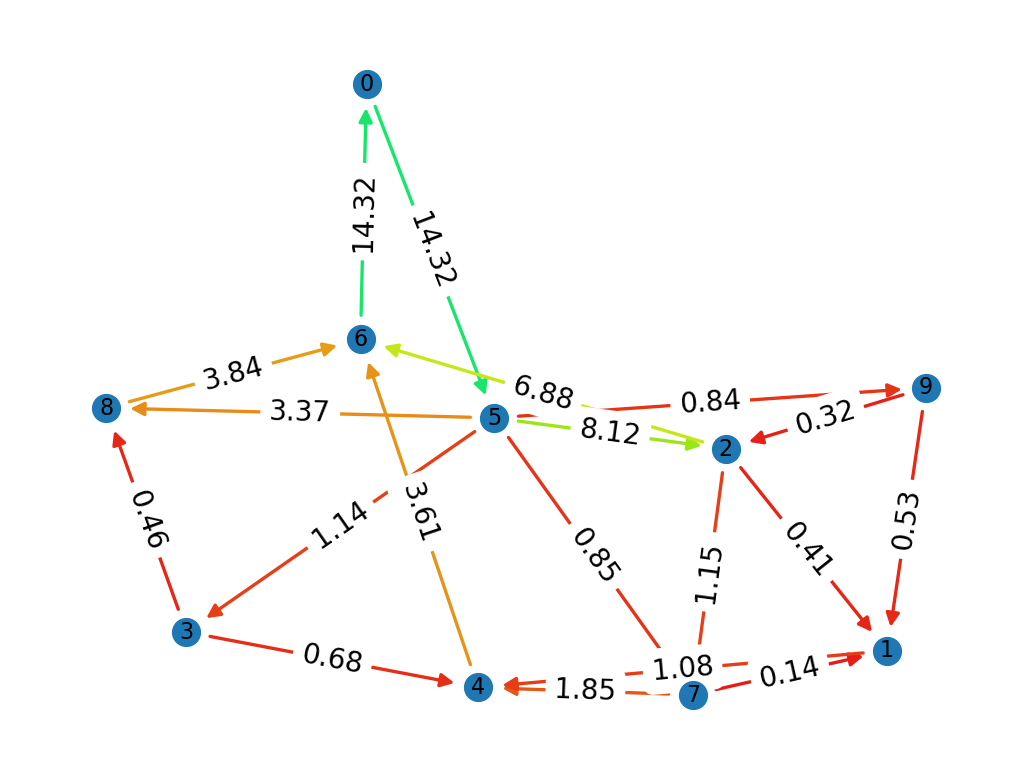

In [155]:
# 10 nodes
circuit = Circuit(filename="./graphs/erdos-renyi/erdos-renyi-10.txt")
circuit.calculate_currents()
circuit.check_circuit(print_msg=True)
circuit.plot_circuit(show_currents=True)

Circuit currents are correct.


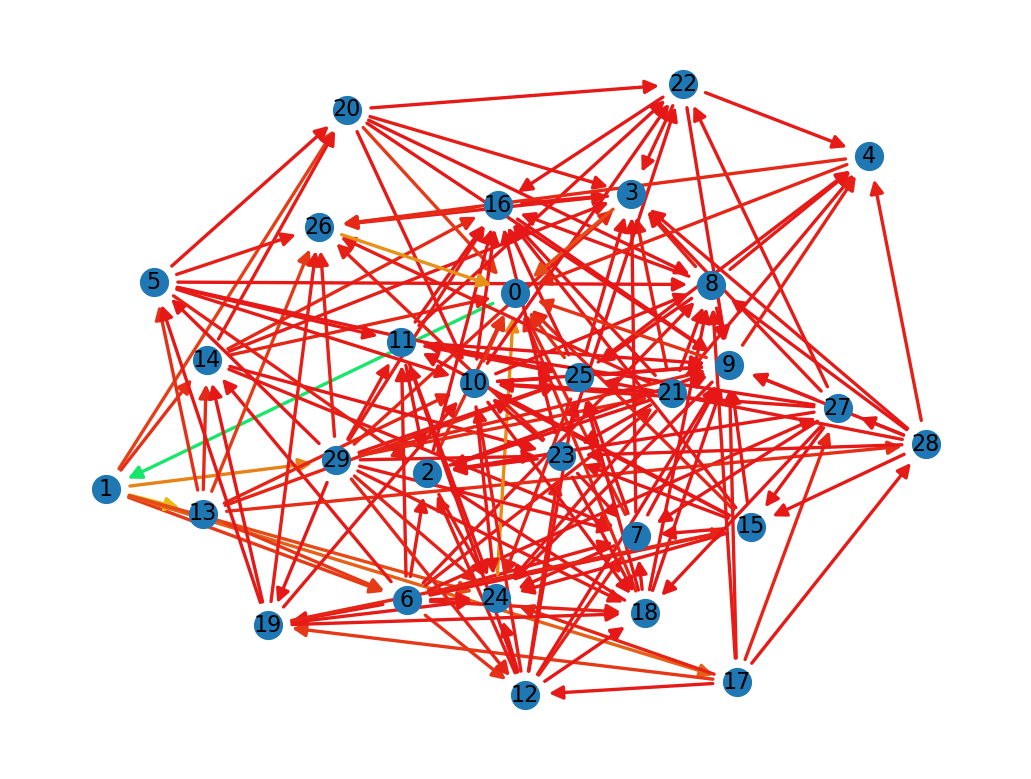

In [156]:
# 30 nodes
circuit = Circuit(filename="./graphs/erdos-renyi/erdos-renyi-30.txt")
circuit.calculate_currents()
circuit.check_circuit(print_msg=True)
circuit.plot_circuit(show_currents=False)

Circuit currents are correct.


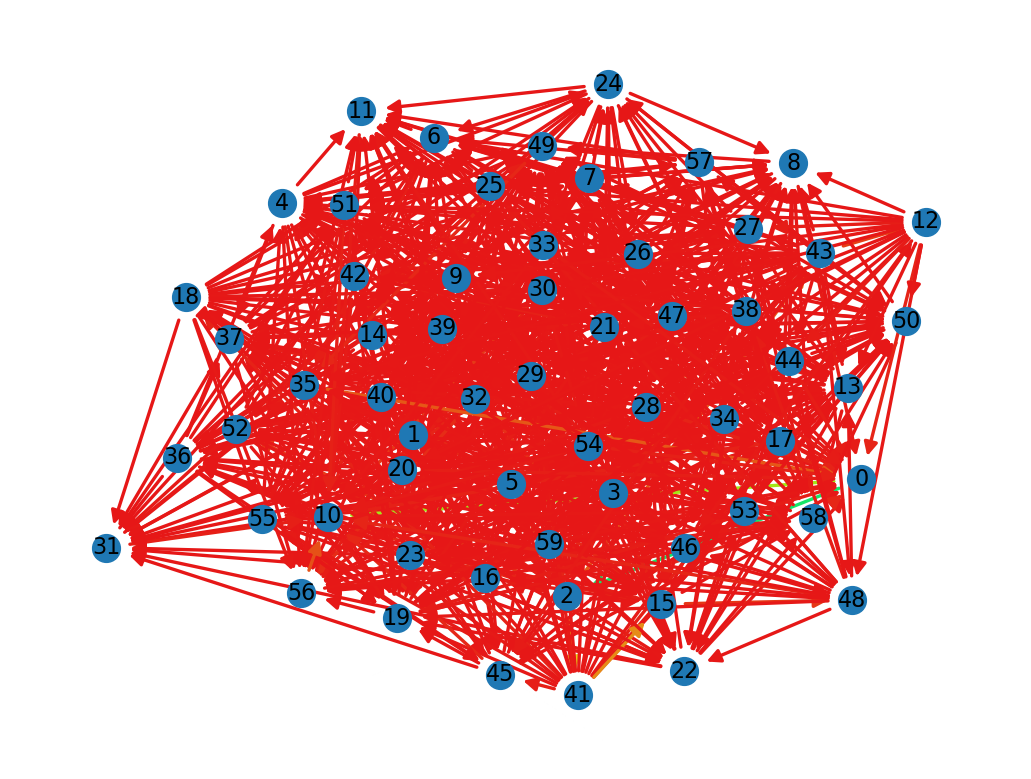

In [157]:
# 60 nodes
circuit = Circuit(filename="./graphs/erdos-renyi/erdos-renyi-60.txt")
circuit.calculate_currents()
circuit.check_circuit(print_msg=True)
circuit.plot_circuit(show_currents=False)

Dla większej liczby wierzchołków przedstawienie grafu jest już nieczytelne, zatem zostały przedstawione tylko testy, czy natężenia zostały prawidłowo obliczone.

In [158]:
# 120 nodes
circuit = Circuit(filename="./graphs/erdos-renyi/erdos-renyi-120.txt")
circuit.calculate_currents()
circuit.check_circuit(print_msg=True);

Circuit currents are correct.


In [159]:
# 200 nodes
circuit = Circuit(filename="./graphs/erdos-renyi/erdos-renyi-200.txt")
circuit.calculate_currents()
circuit.check_circuit(print_msg=True);

Circuit currents are correct.


#### Graf siatka 2D

Circuit currents are correct.


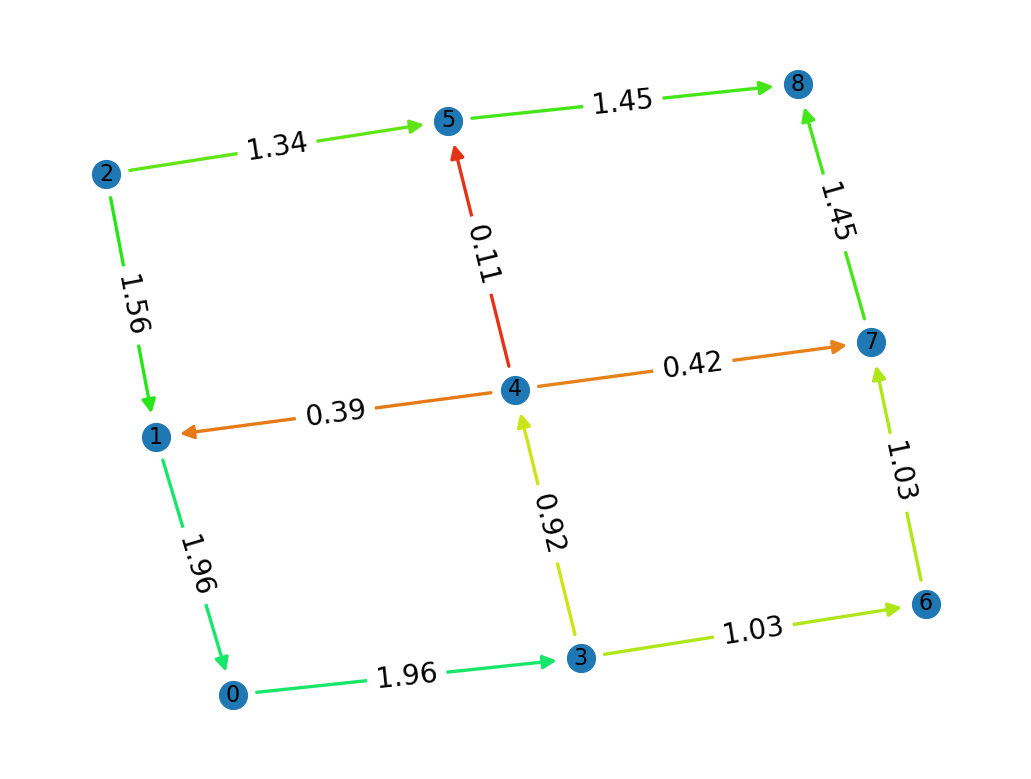

In [5]:
# 9 nodes
circuit = Circuit(filename="./graphs/grid/grid-3x3.txt")
circuit.calculate_currents()
circuit.check_circuit(print_msg=True)
circuit.plot_circuit(show_currents=True)

Circuit currents are correct.


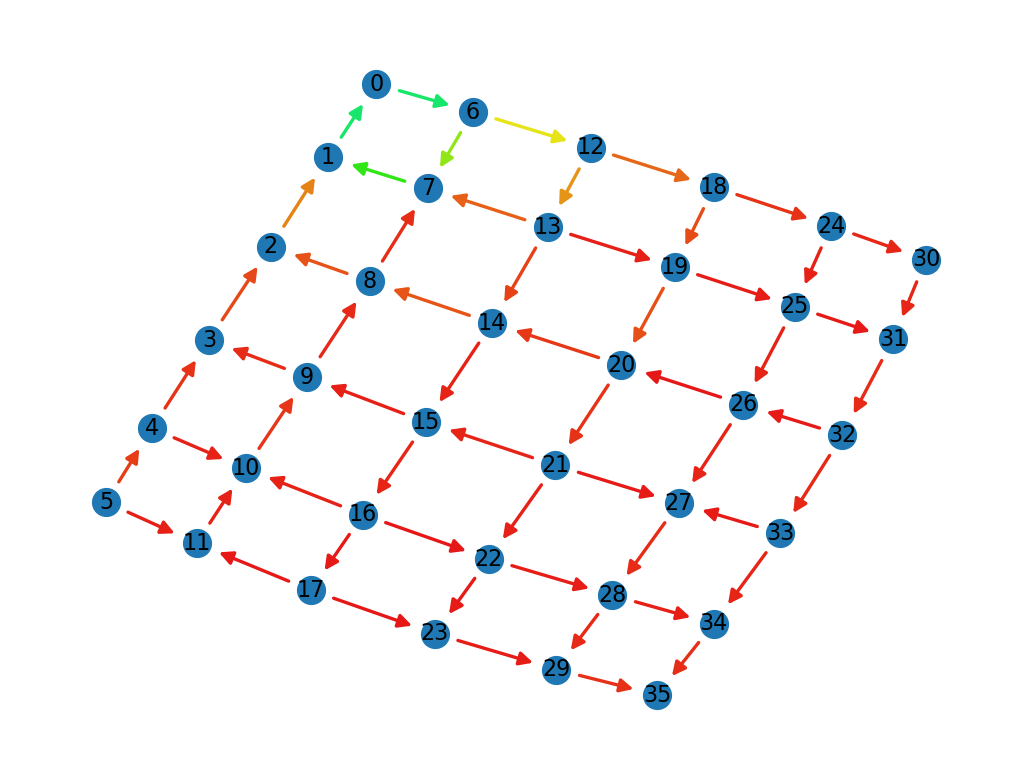

In [18]:
# 36 nodes
circuit = Circuit(filename="./graphs/grid/grid-6x6.txt")
circuit.calculate_currents()
circuit.check_circuit(print_msg=True)
circuit.plot_circuit(show_currents=False)

Circuit currents are correct.


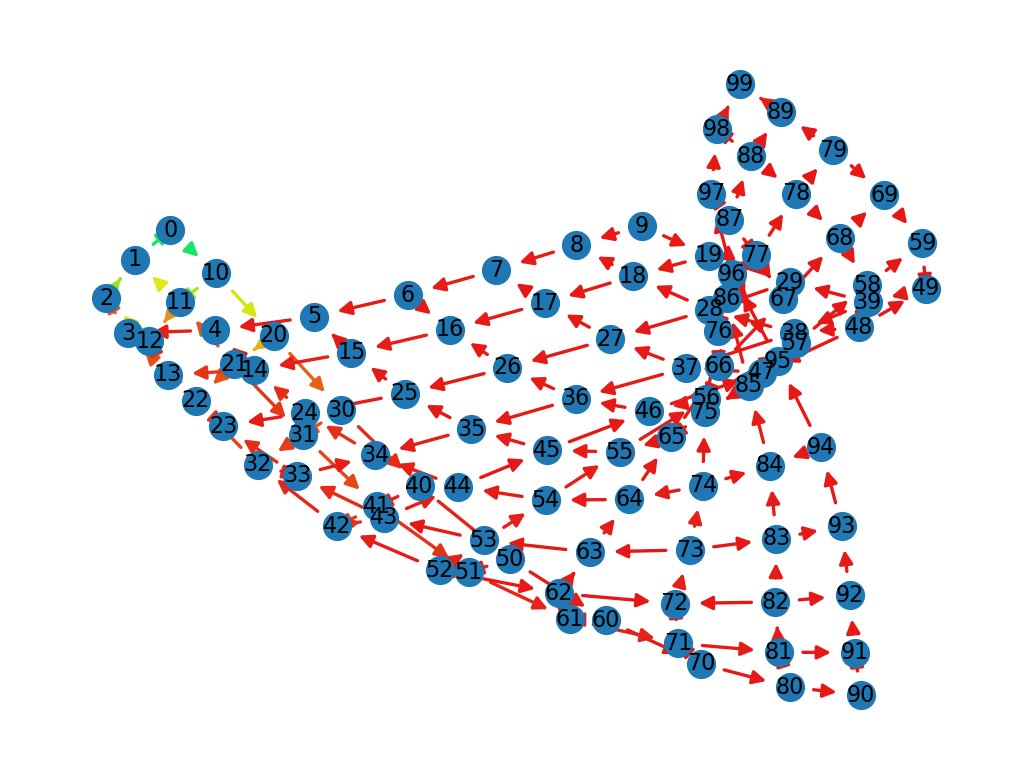

In [19]:
# 100 nodes
circuit = Circuit(filename="./graphs/grid/grid-10x10.txt")
circuit.calculate_currents()
circuit.check_circuit(print_msg=True)
circuit.plot_circuit(show_currents=False)

Dla większej liczby wierzchołków przedstawienie grafu jest już nieczytelne, zatem zostały przedstawione tylko testy, czy natężenia zostały prawidłowo obliczone.

In [20]:
# 144 nodes
circuit = Circuit(filename="./graphs/grid/grid-12x12.txt")
circuit.calculate_currents(approx=True)
circuit.check_circuit(print_msg=True);

Circuit currents are correct.


In [21]:
# 200 nodes
circuit = Circuit(filename="./graphs/grid/grid-20x10.txt")
circuit.calculate_currents(approx=True)
circuit.check_circuit(print_msg=True, epsilon=0.2);

Circuit currents are correct.


#### Graf złożony z dwóch grafów losowych połaczonych mostkiem

Circuit currents are correct.


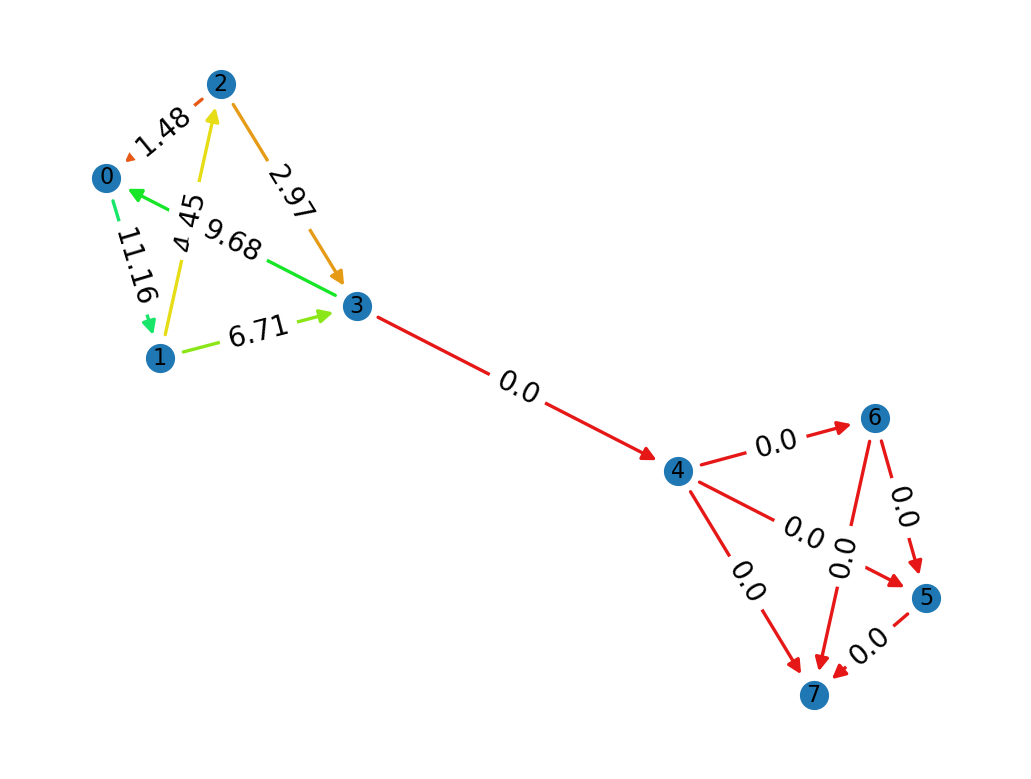

In [22]:
# 8 nodes
circuit = Circuit(filename="./graphs/bridge/bridge-4.txt")
circuit.calculate_currents()
circuit.check_circuit(print_msg=True)
circuit.plot_circuit(show_currents=True)

Circuit currents are correct.


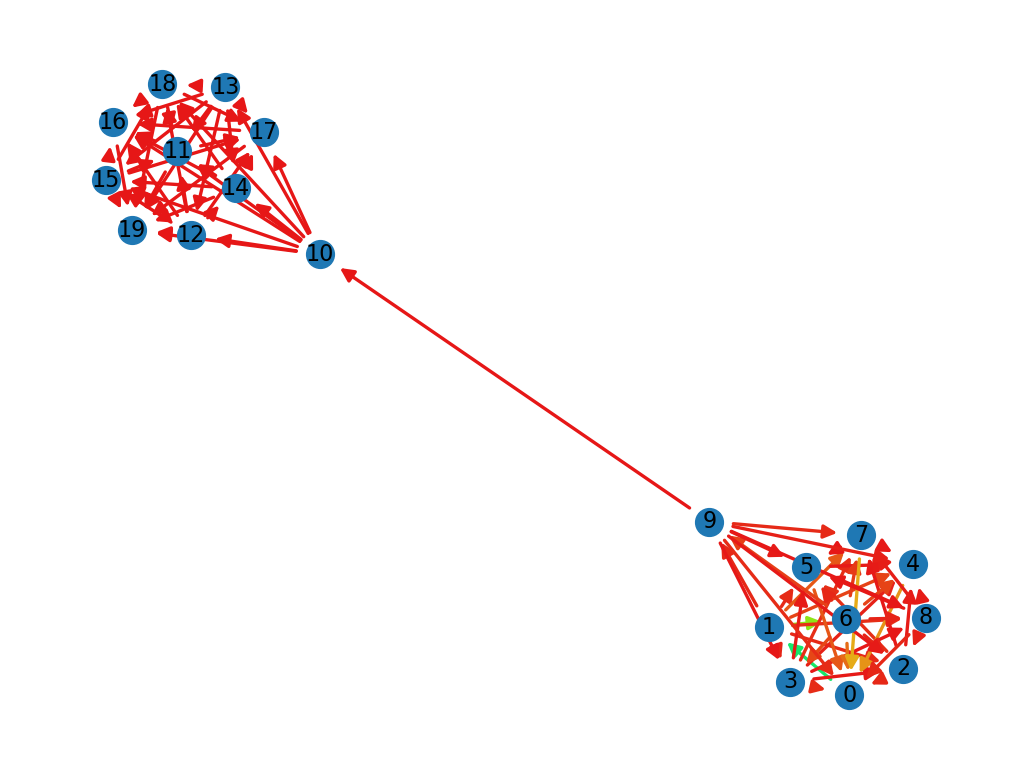

In [23]:
# 20 nodes
circuit = Circuit(filename="./graphs/bridge/bridge-10.txt")
circuit.calculate_currents()
circuit.check_circuit(print_msg=True)
circuit.plot_circuit(show_currents=False)

Dla większej liczby wierzchołków przedstawienie grafu jest już nieczytelne, zatem zostały przedstawione tylko testy, czy natężenia zostały prawidłowo obliczone.

In [111]:
# 100 nodes
circuit = Circuit(filename="./graphs/bridge/bridge-50.txt")
circuit.calculate_currents()
circuit.check_circuit(print_msg=True);

Circuit currents are correct.


In [112]:
# 200 nodes
circuit = Circuit(filename="./graphs/bridge/bridge-100.txt")
circuit.calculate_currents()
circuit.check_circuit(print_msg=True);

Circuit currents are correct.


#### Graf typu small-world

Circuit currents are correct.


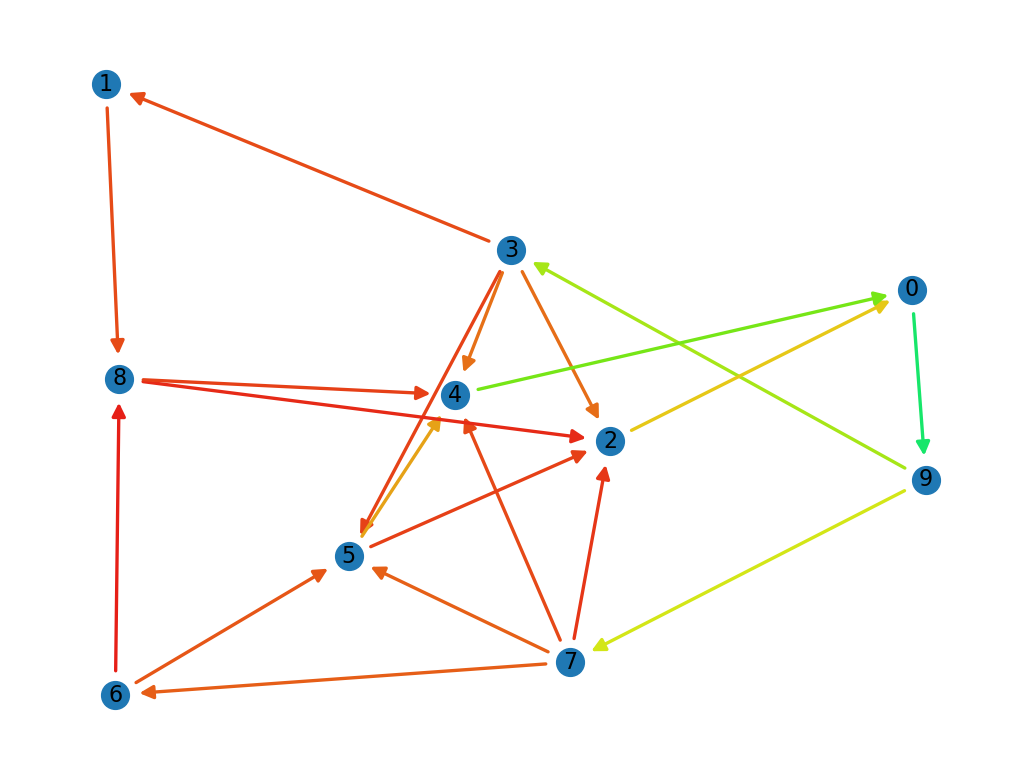

In [208]:
# 10 nodes
circuit = Circuit(filename="./graphs/small-world/sm-10.txt")
circuit.calculate_currents()
circuit.check_circuit(print_msg=True)
circuit.plot_circuit(show_currents=False)

Circuit currents are correct.


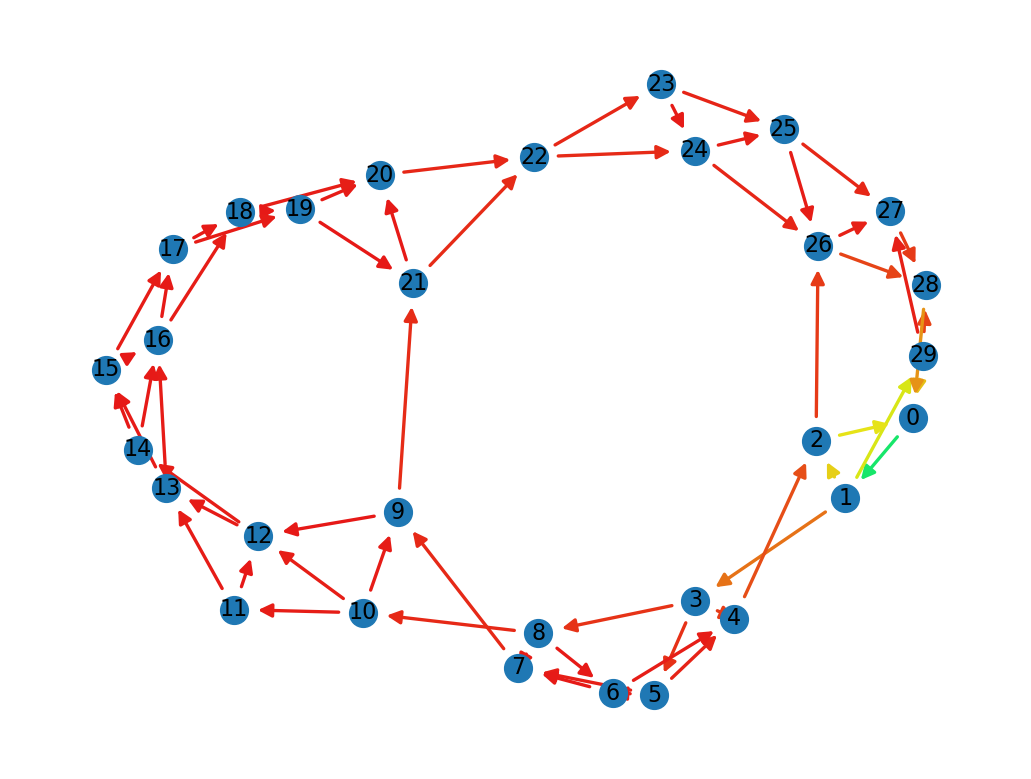

In [228]:
# 30 nodes
circuit = Circuit(filename="./graphs/small-world/sm-30.txt")
circuit.calculate_currents()
circuit.check_circuit(print_msg=True)
circuit.plot_circuit(show_currents=False)

Circuit currents are correct.


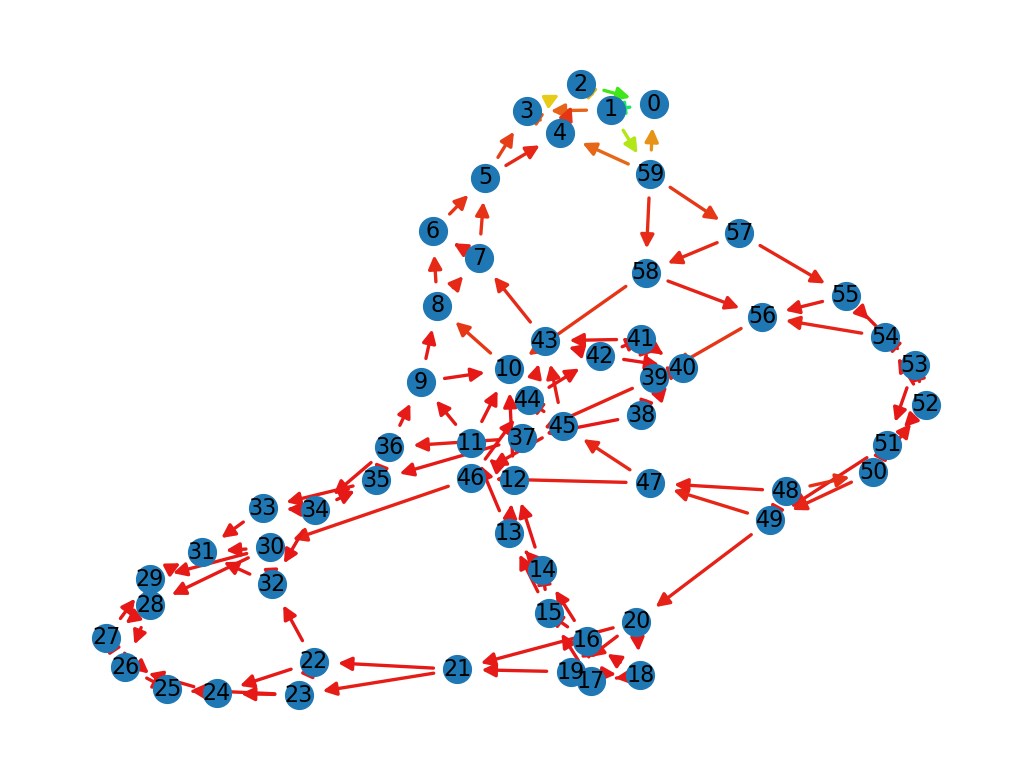

In [53]:
# 60 nodes
circuit = Circuit(filename="./graphs/small-world/sm-60.txt")
circuit.calculate_currents(approx=True)
circuit.check_circuit(print_msg=True)
circuit.plot_circuit(show_currents=False)

Dla większej liczby wierzchołków przedstawienie grafu jest już nieczytelne, zatem zostały przedstawione tylko testy, czy natężenia zostały prawidłowo obliczone.

In [75]:
# 120 nodes
circuit = Circuit(filename="./graphs/small-world/sm-120.txt")
circuit.calculate_currents(approx=True)
circuit.check_circuit(print_msg=True, epsilon=0.41);

Circuit currents are correct.


In [80]:
# 200 nodes
circuit = Circuit(filename="./graphs/small-world/sm-200.txt")
circuit.calculate_currents(approx=True)
circuit.check_circuit(print_msg=True, epsilon=0.37);

Circuit currents are correct.
